In [ ]:
# # Downgrade numpy so it compats with pandas_ta
# pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 75.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [56]:
import vectorbt as vbt
import pandas_ta as ta
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np

# Fetch stock data (YUM in this case)
symbols = ['HON']
#df = vbt.YFData.download(symbols, start='2020-01-01', end='2025-01-01').get('Close')
start_date = '2021-01-01'
end_date = datetime.today()

# price = vbt.YFData.download(symbols, start=start_date, end=end_date, interval='1D',missing_index='drop')

# df = pd.DataFrame()
# df = price.data[symbols[0]]
# df.drop(['Volume', 'Dividends', 'Stock Splits'],axis=1, inplace=True)
# df.index = pd.to_datetime(df.index).strftime('%Y-%m-%d')

#--- using yf.download directly
# import yfinance as yf

# data = yf.download(symbols[0], start=start_date, end=end_date, interval='1d')
# df = data[['Open', 'High', 'Low', 'Close']]
# df.index = df.index.strftime('%Y-%m-%d')


# # write csv to data folder
# df.to_csv('data/hon.csv')
# Display the first few rows

# load amzn.csv from data folder
df = pd.read_csv('data/amzn.csv', index_col='Date', parse_dates=True)
df = df[['Open', 'High', 'Low', 'Close']]
df.index = df.index.strftime('%Y-%m-%d')

#sort the dataframe by index ASC
df.sort_index(inplace=True)
# Display the first few rows
df.head()


,Open,High,Low,Close
Date,,,,
2024-05-30,181.31,181.34,178.36,179.32
2024-05-31,178.30,179.21,173.87,176.44
2024-06-03,177.70,178.70,175.92,178.34
2024-06-04,177.64,179.82,176.44,179.34
2024-06-05,180.10,181.50,178.75,181.28


## Create Feautures for XGBoost

In [58]:
# Import additional libraries for dimension reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# First, let's create more features to make dimension reduction more meaningful
def create_extended_features(df):
    
    """
    Create additional technical indicators to have more features for dimension reduction.
    This demonstrates the value of dimension reduction when dealing with many features.
    """
    # Adding some basic technical indicators using pandas_ta
    df['RSI'] = ta.rsi(df.Close, length=14)
    df['SMA'] = ta.sma(df.Close, length=50)
    df['EMA'] = ta.ema(df.Close, length=50)
    df['ATR'] = ta.atr(high = df.High, low=df.Low, close=df.Close, length=14)
    macd_df = ta.macd(df.Close)
    df['MACD'] = macd_df['MACD_12_26_9']
    df['MACD_signal'] = macd_df['MACDs_12_26_9']

    # Momentum indicators
    df['RSI_21'] = ta.rsi(df.Close, length=21)
    df['Williams_R'] = ta.willr(df.High, df.Low, df.Close, length=14)
    df['ROC'] = ta.roc(df.Close, length=10)
    
    # Moving averages with different periods
    df['SMA_10'] = ta.sma(df.Close, length=10)
    df['SMA_20'] = ta.sma(df.Close, length=20)
    df['EMA_12'] = ta.ema(df.Close, length=12)
    df['EMA_26'] = ta.ema(df.Close, length=26)
    
    # Volatility indicators
    df['BBANDS_upper'], df['BBANDS_middle'], df['BBANDS_lower'] = ta.bbands(df.Close, length=20).iloc[:, 0], ta.bbands(df.Close, length=20).iloc[:, 1], ta.bbands(df.Close, length=20).iloc[:, 2]
    df['BB_width'] = df['BBANDS_upper'] - df['BBANDS_lower']
    df['BB_position'] = (df['Close'] - df['BBANDS_lower']) / (df['BBANDS_upper'] - df['BBANDS_lower'])
    
    # Volume indicators (if volume data was available)
    # df['Volume_SMA'] = ta.sma(df.Volume, length=20)
    # df['Volume_ratio'] = df.Volume / df['Volume_SMA']
    
    # Price-based features
    df['High_Low_ratio'] = df['High'] / df['Low']
    df['Close_Open_ratio'] = df['Close'] / df['Open']
    df['Price_change'] = df['Close'].pct_change()
    df['Price_change_3d'] = df['Close'].pct_change(periods=3)
    
    # Lag features (previous day values)
    df['Close_lag1'] = df['Close'].shift(1)
    df['Close_lag2'] = df['Close'].shift(2)
    df['RSI_lag1'] = df['RSI'].shift(1)
    
    return df

# Apply extended feature creation
df = create_extended_features(df)

# Define extended feature list
extended_features = [
    'RSI', 'SMA', 'EMA', 'ATR', 'MACD', 'MACD_signal',
    'RSI_21', 
    'Williams_R', 'ROC', 'SMA_10', 'SMA_20', 
    'EMA_12', 'EMA_26', 'BBANDS_upper', 'BBANDS_middle', 
    'BBANDS_lower', 'BB_width', 'BB_position', 'High_Low_ratio',
    'Close_Open_ratio', 'Price_change', 'Price_change_3d',
    'Close_lag1', 'Close_lag2', 'RSI_lag1'
]

# Create the target signal based on 3 consecutive green/red candles

def create_trading_signal(df):
    df['Signal'] = 0  # Default to no action
    buy_count = 0  # Track the number of buys executed
    
    for i in range(2, len(df) - 1):  # Start from index 2 to check previous 3 candles
        if df['Close'].iloc[i] > df['Close'].iloc[i - 1] and df['Close'].iloc[i - 1] > df['Close'].iloc[i - 2]:
            # 3 consecutive green candles
            if buy_count < 3:
                df.at[df.index[i + 1], 'Signal'] = 1  # Buy on the fourth day
                buy_count += 1
        elif df['Close'].iloc[i] < df['Close'].iloc[i - 1] and df['Close'].iloc[i - 1] < df['Close'].iloc[i - 2]:
            # 3 consecutive red candles
            if buy_count > 0:
                df.at[df.index[i + 1], 'Signal'] = -1  # Sell on the fourth day
                buy_count = 0  # Reset buy count after selling
            else:
                df.at[df.index[i + 1], 'Signal'] = 0  # Do nothing if no prior buy
    
    return df

# Apply the function to generate trading signals
df = create_trading_signal(df)

# Display the updated DataFrame
df[['Close', 'Signal']].tail(20)
print(f"Total features created: {len(extended_features)}")

Total features created: 25


In [60]:
df_clean

,Open,High,Low,Close,RSI,SMA,EMA,ATR,MACD,MACD_signal,...,BB_width,BB_position,High_Low_ratio,Close_Open_ratio,Price_change,Price_change_3d,Close_lag1,Close_lag2,RSI_lag1,Signal
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-09,166.40,168.55,165.85,166.94,35.222711,184.9824,184.982400,6.617848,-6.147549,-4.086148,...,-40.220306,0.793645,1.016280,1.003245,0.006876,0.030939,165.80,162.77,33.473892,1
2024-08-12,168.14,168.55,166.11,166.80,35.100678,184.7320,184.269365,6.311907,-6.116402,-4.492199,...,-39.356489,0.770718,1.014689,0.992030,-0.000839,0.024759,166.94,165.80,35.222711,1
2024-08-13,167.81,171.04,167.10,170.23,40.536378,184.6078,183.718801,6.160456,-5.748678,-4.743495,...,-37.095616,0.664036,1.023579,1.014421,0.020564,0.026719,166.80,166.94,35.100678,0
2024-08-14,172.11,172.28,168.86,170.10,40.398272,184.4430,183.184731,5.960469,-5.405434,-4.875882,...,-35.865621,0.648429,1.020253,0.988321,-0.000764,0.018929,170.23,166.80,40.536378,0
2024-08-15,174.86,177.91,173.99,177.59,50.799007,184.4080,182.965330,6.095231,-4.477417,-4.796189,...,-35.115743,0.429533,1.022530,1.015612,0.044033,0.064688,170.10,170.23,40.398272,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,198.90,202.37,197.85,200.99,54.930407,191.0998,196.562939,6.436773,4.315724,3.993223,...,-36.444414,0.392384,1.022846,1.010508,-0.010389,-0.015093,203.10,201.12,57.505164,0
2025-05-27,203.09,206.69,202.19,206.02,59.576938,191.2612,196.933804,6.384147,4.384789,4.071536,...,-36.175593,0.277861,1.022256,1.014427,0.025026,0.024364,200.99,203.10,54.930407,0
2025-05-28,205.92,207.66,204.41,204.72,57.915069,191.4408,197.239145,6.160279,4.285228,4.114274,...,-35.258659,0.333530,1.015899,0.994172,-0.006310,0.007976,206.02,200.99,59.576938,0


In [59]:
# Clean the data and prepare for dimension reduction
df_clean = df.copy()

# Drop rows with NaN values
df_clean.dropna(inplace=True)

# Prepare features and target
X_extended = df_clean[extended_features]
y_extended = df_clean['Signal']

print(f"Dataset shape after cleaning: {X_extended.shape}")
print(f"Features: {X_extended.columns.tolist()}")

# Check for any remaining NaN values
print(f"NaN values in features: {X_extended.isnull().sum().sum()}")
print(f"NaN values in target: {y_extended.isnull().sum()}")

Dataset shape after cleaning: (202, 25)
Features: ['RSI', 'SMA', 'EMA', 'ATR', 'MACD', 'MACD_signal', 'RSI_21', 'Williams_R', 'ROC', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26', 'BBANDS_upper', 'BBANDS_middle', 'BBANDS_lower', 'BB_width', 'BB_position', 'High_Low_ratio', 'Close_Open_ratio', 'Price_change', 'Price_change_3d', 'Close_lag1', 'Close_lag2', 'RSI_lag1']
NaN values in features: 0
NaN values in target: 0


Removed 14 highly correlated features: ['EMA_12', 'RSI', 'SMA_20', 'EMA_26', 'MACD_signal', 'BBANDS_middle', 'BBANDS_lower', 'BBANDS_upper', 'MACD', 'Williams_R', 'EMA', 'SMA_10', 'Close_lag2', 'RSI_lag1']
Remaining features: 11


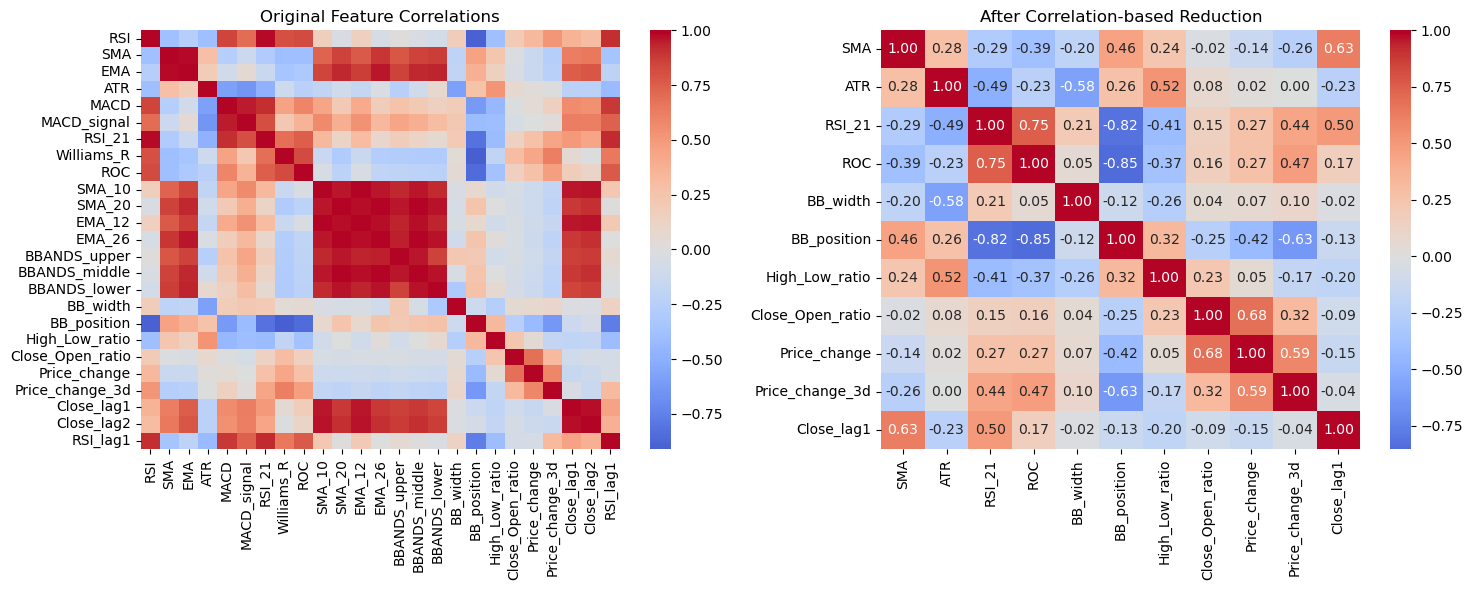

In [61]:
# DIMENSION REDUCTION TECHNIQUE 1: CORRELATION-BASED FEATURE REMOVAL
def remove_highly_correlated_features(X, threshold=0.95):
    """
    Remove features that are highly correlated with other features.
    High correlation indicates redundancy in features.
    
    Args:
        X: Feature matrix
        threshold: Correlation threshold above which features are considered redundant
    
    Returns:
        X_reduced: Feature matrix with highly correlated features removed
        removed_features: List of removed feature names
    """
    # Calculate correlation matrix
    corr_matrix = X.corr().abs()
    
    # Create a mask for the upper triangle (to avoid duplicate comparisons)
    upper_triangle = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    
    # Find features to remove (correlation > threshold)
    to_remove = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                # Remove the feature with lower mean correlation to all other features
                mean_corr_i = corr_matrix.iloc[i, :].mean()
                mean_corr_j = corr_matrix.iloc[j, :].mean()
                if mean_corr_i > mean_corr_j:
                    to_remove.append(corr_matrix.columns[j])
                else:
                    to_remove.append(corr_matrix.columns[i])
    
    # Remove duplicates and create reduced feature set
    to_remove = list(set(to_remove))
    X_reduced = X.drop(columns=to_remove)
    
    print(f"Removed {len(to_remove)} highly correlated features: {to_remove}")
    print(f"Remaining features: {X_reduced.shape[1]}")
    
    return X_reduced, to_remove

# Apply correlation-based feature removal
X_corr_reduced, removed_corr_features = remove_highly_correlated_features(X_extended, threshold=0.9)

# Visualize correlation matrix before and after
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.heatmap(X_extended.corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Original Feature Correlations')

plt.subplot(1, 2, 2)
sns.heatmap(X_corr_reduced.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('After Correlation-based Reduction')

plt.tight_layout()
plt.show()

PCA Reduction Results:
Original dimensions: 11
Reduced dimensions: 7
Variance preserved: 0.955 (95.5%)
Compression ratio: 1.57:1


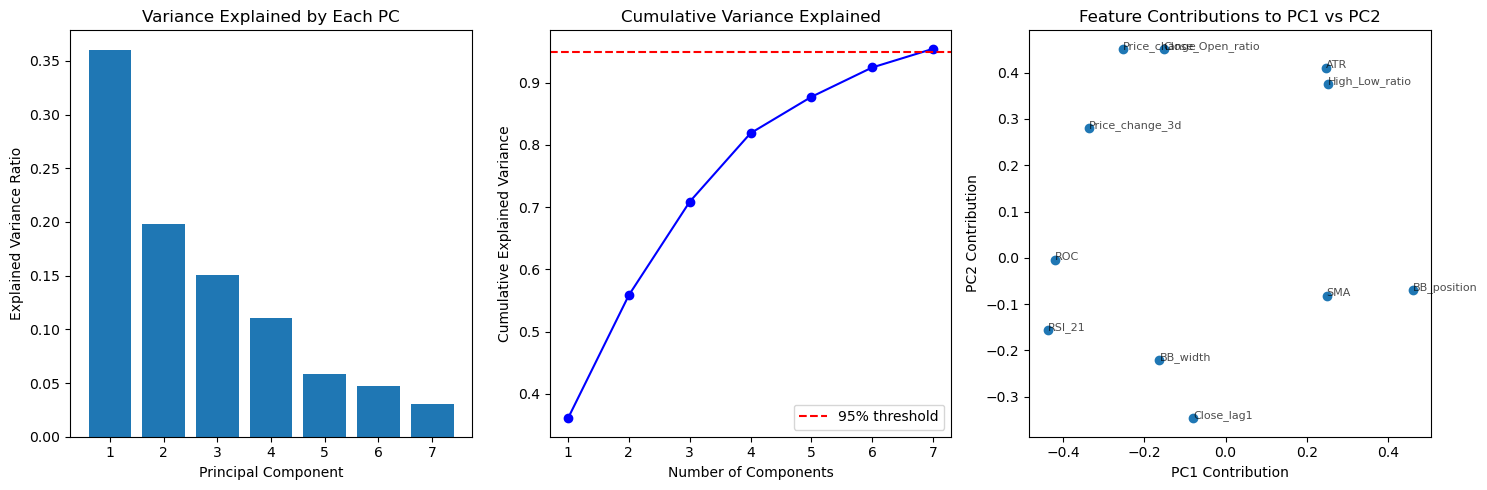

In [62]:
# DIMENSION REDUCTION TECHNIQUE 2: PRINCIPAL COMPONENT ANALYSIS (PCA)
def apply_pca_reduction(X, n_components=None, variance_threshold=0.95):
    """
    Apply PCA for dimension reduction while preserving specified variance.
    
    PCA finds the principal components (linear combinations of original features)
    that capture the most variance in the data. This helps reduce noise and
    computational complexity while retaining most of the information.
    
    Args:
        X: Feature matrix
        n_components: Number of components to keep (if None, use variance_threshold)
        variance_threshold: Minimum cumulative variance to preserve
    
    Returns:
        X_pca: Transformed feature matrix
        pca: Fitted PCA object
        n_components_used: Number of components actually used
    """
    # Standardize features (important for PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    if n_components is None:
        # Determine number of components needed for variance threshold
        pca_temp = PCA()
        pca_temp.fit(X_scaled)
        cumsum_variance = np.cumsum(pca_temp.explained_variance_ratio_)
        n_components = np.argmax(cumsum_variance >= variance_threshold) + 1
    
    # Apply PCA with determined number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Print information about the reduction
    total_variance = np.sum(pca.explained_variance_ratio_)
    print(f"PCA Reduction Results:")
    print(f"Original dimensions: {X.shape[1]}")
    print(f"Reduced dimensions: {n_components}")
    print(f"Variance preserved: {total_variance:.3f} ({total_variance*100:.1f}%)")
    print(f"Compression ratio: {X.shape[1]/n_components:.2f}:1")
    
    # Create DataFrame with PCA components
    pca_columns = [f'PC{i+1}' for i in range(n_components)]
    X_pca_df = pd.DataFrame(X_pca, index=X.index, columns=pca_columns)
    
    return X_pca_df, pca, scaler, n_components

# Apply PCA to correlation-reduced features
X_pca, pca_model, pca_scaler, n_pca_components = apply_pca_reduction(
    X_corr_reduced, 
    variance_threshold=0.95
)

# Visualize PCA results
plt.figure(figsize=(15, 5))

# Plot 1: Explained variance ratio
plt.subplot(1, 3, 1)
plt.bar(range(1, len(pca_model.explained_variance_ratio_) + 1), 
        pca_model.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by Each PC')

# Plot 2: Cumulative explained variance
plt.subplot(1, 3, 2)
cumsum_variance = np.cumsum(pca_model.explained_variance_ratio_)
plt.plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained')
plt.legend()

# Plot 3: Feature contributions to first two PCs
plt.subplot(1, 3, 3)
feature_contributions = pca_model.components_[:2].T
plt.scatter(feature_contributions[:, 0], feature_contributions[:, 1])
plt.xlabel('PC1 Contribution')
plt.ylabel('PC2 Contribution')
plt.title('Feature Contributions to PC1 vs PC2')

# Add feature labels
for i, feature in enumerate(X_corr_reduced.columns):
    plt.annotate(feature, (feature_contributions[i, 0], feature_contributions[i, 1]), 
                fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

Univariate Feature Selection Results:
Selected 8 features out of 11
Selected features: ['SMA', 'RSI_21', 'ROC', 'BB_width', 'BB_position', 'High_Low_ratio', 'Close_Open_ratio', 'Price_change_3d']

Top 10 feature scores:
             Feature      Score  Selected
9    Price_change_3d  24.542610      True
5        BB_position   3.572307      True
7   Close_Open_ratio   1.736266      True
6     High_Low_ratio   1.462027      True
2             RSI_21   1.105527      True
3                ROC   1.061617      True
0                SMA   0.566595      True
4           BB_width   0.534427      True
8       Price_change   0.441581     False
10        Close_lag1   0.085078     False


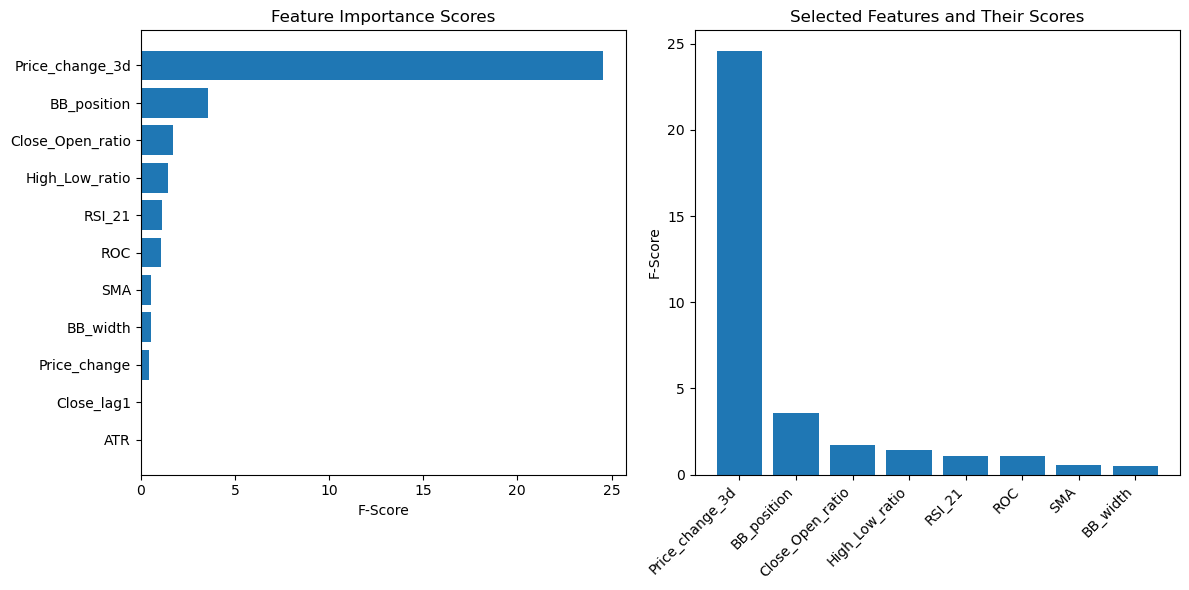

In [63]:
# DIMENSION REDUCTION TECHNIQUE 3: UNIVARIATE FEATURE SELECTION
def apply_univariate_selection(X, y, k=10):
    """
    Select k best features based on univariate statistical tests.
    
    This method evaluates each feature individually against the target variable
    using statistical tests (F-test for classification). Features with the
    highest scores are selected.
    
    Args:
        X: Feature matrix
        y: Target variable
        k: Number of features to select
    
    Returns:
        X_selected: Feature matrix with selected features
        selector: Fitted SelectKBest object
        selected_features: Names of selected features
    """
    # Apply SelectKBest with f_classif scoring function
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    
    # Get selected feature names
    selected_features = X.columns[selector.get_support()].tolist()
    
    # Get feature scores
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': selector.scores_,
        'Selected': selector.get_support()
    }).sort_values('Score', ascending=False)
    
    print(f"Univariate Feature Selection Results:")
    print(f"Selected {k} features out of {X.shape[1]}")
    print(f"Selected features: {selected_features}")
    print("\nTop 10 feature scores:")
    print(feature_scores.head(10))
    
    # Create DataFrame with selected features
    X_selected_df = pd.DataFrame(X_selected, index=X.index, columns=selected_features)
    
    return X_selected_df, selector, selected_features, feature_scores

# Apply univariate feature selection
X_univariate, univariate_selector, selected_features, feature_scores = apply_univariate_selection(
    X_corr_reduced, y_extended, k=8
)

# Visualize feature selection results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(range(len(feature_scores)), feature_scores['Score'])
plt.yticks(range(len(feature_scores)), feature_scores['Feature'])
plt.xlabel('F-Score')
plt.title('Feature Importance Scores')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
selected_scores = feature_scores[feature_scores['Selected']]['Score']
plt.bar(range(len(selected_scores)), selected_scores)
plt.xticks(range(len(selected_scores)), 
           feature_scores[feature_scores['Selected']]['Feature'], 
           rotation=45, ha='right')
plt.ylabel('F-Score')
plt.title('Selected Features and Their Scores')

plt.tight_layout()
plt.show()

RFE Results:
Selected 6 features out of 11
Selected features: ['RSI_21', 'ROC', 'High_Low_ratio', 'Close_Open_ratio', 'Price_change', 'Price_change_3d']

Feature rankings:
             Feature  Ranking  Selected
2             RSI_21        1      True
3                ROC        1      True
6     High_Low_ratio        1      True
7   Close_Open_ratio        1      True
8       Price_change        1      True
9    Price_change_3d        1      True
4           BB_width        2     False
0                SMA        3     False
5        BB_position        4     False
1                ATR        5     False
10        Close_lag1        6     False


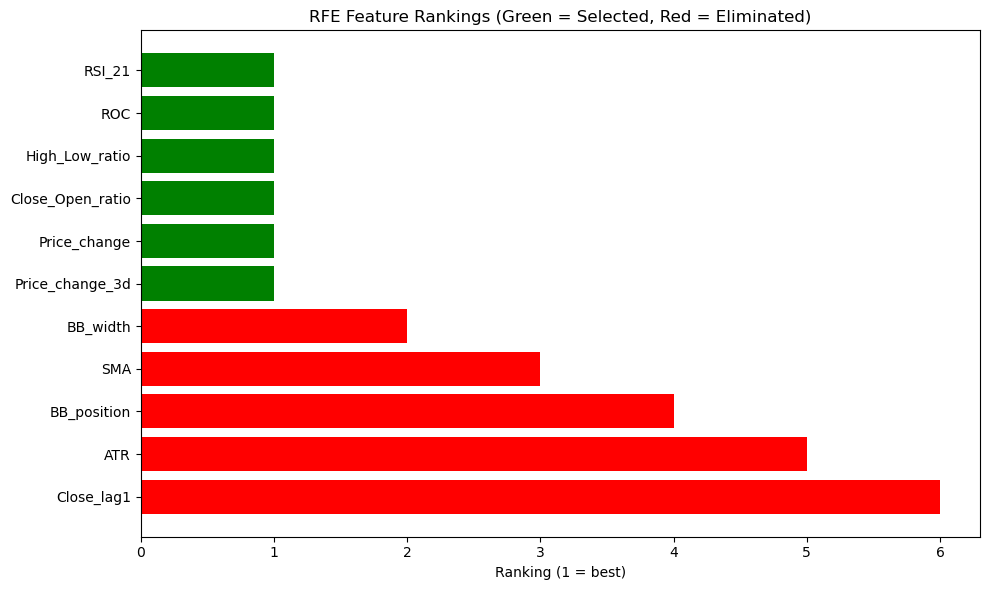

In [64]:
# DIMENSION REDUCTION TECHNIQUE 4: RECURSIVE FEATURE ELIMINATION (RFE)
def apply_rfe_selection(X, y, n_features=8, estimator=None):
    """
    Apply Recursive Feature Elimination using XGBoost as the estimator.
    
    RFE works by recursively eliminating features and building the model
    on the remaining attributes. It uses the model's feature importance
    to eliminate the least important features.
    
    Args:
        X: Feature matrix
        y: Target variable
        n_features: Number of features to select
        estimator: Base estimator (if None, uses XGBoost)
    
    Returns:
        X_rfe: Feature matrix with selected features
        rfe: Fitted RFE object
        selected_features: Names of selected features
    """
    if estimator is None:
        # Use XGBoost as the base estimator for RFE
        estimator = xgb.XGBClassifier(
            objective='multi:softmax',
            num_class=3,
            eval_metric='mlogloss',
            learning_rate=0.1,
            max_depth=6,
            random_state=42,
            verbosity=0
        )
    
    # Map target values for XGBoost classifier
    y_mapped = y.map({-1: 0, 0: 1, 1: 2})
    
    # Apply RFE
    rfe = RFE(estimator=estimator, n_features_to_select=n_features, step=1)
    X_rfe = rfe.fit_transform(X, y_mapped)
    
    # Get selected feature names
    selected_features = X.columns[rfe.support_].tolist()
    
    # Get feature rankings
    feature_rankings = pd.DataFrame({
        'Feature': X.columns,
        'Ranking': rfe.ranking_,
        'Selected': rfe.support_
    }).sort_values('Ranking')
    
    print(f"RFE Results:")
    print(f"Selected {n_features} features out of {X.shape[1]}")
    print(f"Selected features: {selected_features}")
    print("\nFeature rankings:")
    print(feature_rankings)
    
    # Create DataFrame with selected features
    X_rfe_df = pd.DataFrame(X_rfe, index=X.index, columns=selected_features)
    
    return X_rfe_df, rfe, selected_features, feature_rankings

# Apply RFE selection
X_rfe, rfe_selector, rfe_selected_features, feature_rankings = apply_rfe_selection(
    X_corr_reduced, y_extended, n_features=6
)

# Visualize RFE results
plt.figure(figsize=(10, 6))
colors = ['green' if selected else 'red' for selected in feature_rankings['Selected']]
plt.barh(range(len(feature_rankings)), feature_rankings['Ranking'], color=colors)
plt.yticks(range(len(feature_rankings)), feature_rankings['Feature'])
plt.xlabel('Ranking (1 = best)')
plt.title('RFE Feature Rankings (Green = Selected, Red = Eliminated)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [65]:
# COMPARISON OF DIMENSION REDUCTION TECHNIQUES
def compare_dimension_reduction_methods(X_sets, y, method_names):
    """
    Compare different dimension reduction methods by training XGBoost models
    and evaluating their performance.
    
    Args:
        X_sets: List of feature matrices from different reduction methods
        y: Target variable
        method_names: Names of the reduction methods
    
    Returns:
        results: DataFrame with comparison results
    """
    results = []
    
    for i, (X, method_name) in enumerate(zip(X_sets, method_names)):
        print(f"\nEvaluating {method_name}...")
        print(f"Features shape: {X.shape}")
        
        # Split data (time-based split)
        X_sorted = X.sort_index()
        y_sorted = y.sort_index()
        
        split_point = int(len(X_sorted) * 0.7)
        X_train = X_sorted.iloc[:split_point]
        X_test = X_sorted.iloc[split_point:]
        y_train = y_sorted.iloc[:split_point]
        y_test = y_sorted.iloc[split_point:]
        
        # Map target values
        y_train_mapped = y_train.map({-1: 0, 0: 1, 1: 2})
        y_test_mapped = y_test.map({-1: 0, 0: 1, 1: 2})
        
        # Train XGBoost model
        dtrain = xgb.DMatrix(X_train, label=y_train_mapped)
        dtest = xgb.DMatrix(X_test, label=y_test_mapped)
        
        params = {
            'objective': 'multi:softmax',
            'num_class': 3,
            'eval_metric': 'mlogloss',
            'eta': 0.1,
            'max_depth': 6,
            'seed': 42,
            'verbosity': 0
        }
        
        # Train model with early stopping
        evals = [(dtrain, 'train'), (dtest, 'test')]
        bst = xgb.train(
            params, dtrain, 
            num_boost_round=100,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False
        )
        
        # Make predictions
        y_pred = bst.predict(dtest)
        
        # Calculate accuracy
        accuracy = np.mean(y_pred == y_test_mapped)
        
        # Get best iteration and test error
        best_iteration = bst.best_iteration
        test_error = bst.best_score
        
        results.append({
            'Method': method_name,
            'Features': X.shape[1],
            'Accuracy': accuracy,
            'Test_Error': test_error,
            'Best_Iteration': best_iteration,
            'Feature_Names': list(X.columns) if hasattr(X, 'columns') else None
        })
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Test Error: {test_error:.4f}")
    
    return pd.DataFrame(results)

# Prepare datasets for comparison
comparison_datasets = [
    X_extended,  # Original features
    X_corr_reduced,  # Correlation-based reduction
    X_pca,  # PCA reduction
    X_univariate,  # Univariate selection
    X_rfe  # RFE selection
]

method_names = [
    'Original Features',
    'Correlation Reduction',
    'PCA',
    'Univariate Selection',
    'RFE Selection'
]

# Compare methods
comparison_results = compare_dimension_reduction_methods(
    comparison_datasets, y_extended, method_names
)

print("\n" + "="*50)
print("DIMENSION REDUCTION COMPARISON RESULTS")
print("="*50)
print(comparison_results.to_string(index=False))


Evaluating Original Features...
Features shape: (202, 25)
Accuracy: 0.6721
Test Error: 0.7500

Evaluating Correlation Reduction...
Features shape: (202, 11)
Accuracy: 0.6557
Test Error: 0.7527

Evaluating PCA...
Features shape: (202, 7)
Accuracy: 0.5738
Test Error: 0.7941

Evaluating Univariate Selection...
Features shape: (202, 8)
Accuracy: 0.6393
Test Error: 0.7791

Evaluating RFE Selection...
Features shape: (202, 6)
Accuracy: 0.6885
Test Error: 0.6926

DIMENSION REDUCTION COMPARISON RESULTS
               Method  Features  Accuracy  Test_Error  Best_Iteration                                                                                                                                                                                                                                                         Feature_Names
    Original Features        25  0.672131    0.750034              17 [RSI, SMA, EMA, ATR, MACD, MACD_signal, RSI_21, Williams_R, ROC, SMA_10, SMA_20, EMA_12, EMA_26, 

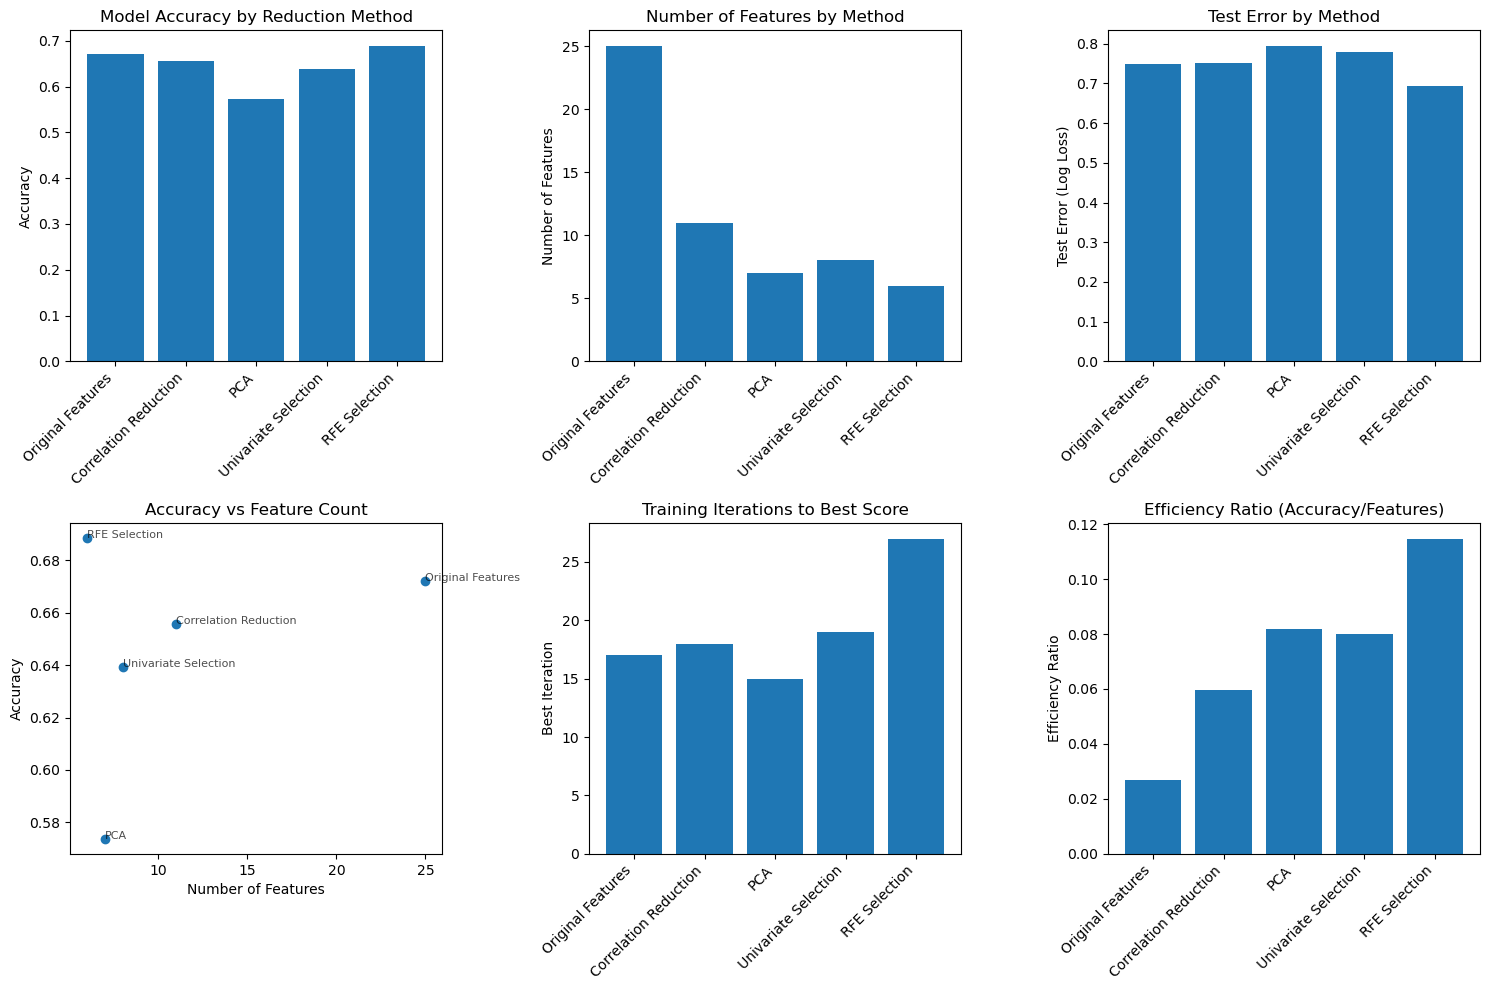


BEST PERFORMING METHOD
Method: RFE Selection
Features: 6
Accuracy: 0.6885
Test Error: 0.6926


In [66]:
# VISUALIZE COMPARISON RESULTS
plt.figure(figsize=(15, 10))

# Plot 1: Accuracy comparison
plt.subplot(2, 3, 1)
plt.bar(comparison_results['Method'], comparison_results['Accuracy'])
plt.title('Model Accuracy by Reduction Method')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')

# Plot 2: Number of features
plt.subplot(2, 3, 2)
plt.bar(comparison_results['Method'], comparison_results['Features'])
plt.title('Number of Features by Method')
plt.ylabel('Number of Features')
plt.xticks(rotation=45, ha='right')

# Plot 3: Test error
plt.subplot(2, 3, 3)
plt.bar(comparison_results['Method'], comparison_results['Test_Error'])
plt.title('Test Error by Method')
plt.ylabel('Test Error (Log Loss)')
plt.xticks(rotation=45, ha='right')

# Plot 4: Accuracy vs Number of Features
plt.subplot(2, 3, 4)
plt.scatter(comparison_results['Features'], comparison_results['Accuracy'])
for i, method in enumerate(comparison_results['Method']):
    plt.annotate(method, 
                (comparison_results['Features'].iloc[i], 
                 comparison_results['Accuracy'].iloc[i]),
                fontsize=8, alpha=0.7)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Feature Count')

# Plot 5: Training efficiency (Best iteration)
plt.subplot(2, 3, 5)
plt.bar(comparison_results['Method'], comparison_results['Best_Iteration'])
plt.title('Training Iterations to Best Score')
plt.ylabel('Best Iteration')
plt.xticks(rotation=45, ha='right')

# Plot 6: Efficiency ratio (Accuracy per Feature)
plt.subplot(2, 3, 6)
efficiency_ratio = comparison_results['Accuracy'] / comparison_results['Features']
plt.bar(comparison_results['Method'], efficiency_ratio)
plt.title('Efficiency Ratio (Accuracy/Features)')
plt.ylabel('Efficiency Ratio')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Select the best performing method
best_method_idx = comparison_results['Accuracy'].idxmax()
best_method = comparison_results.iloc[best_method_idx]

print(f"\n" + "="*50)
print("BEST PERFORMING METHOD")
print("="*50)
print(f"Method: {best_method['Method']}")
print(f"Features: {best_method['Features']}")
print(f"Accuracy: {best_method['Accuracy']:.4f}")
print(f"Test Error: {best_method['Test_Error']:.4f}")

In [67]:
# IMPLEMENT FINAL MODEL WITH BEST DIMENSION REDUCTION METHOD
def implement_final_model_with_reduction():
    """
    Implement the final trading model using the best dimension reduction method.
    This function shows how to integrate dimension reduction into your trading pipeline.
    """
    # Based on comparison results, select the best method
    # if RFE performed best
    print("Implementing final model with RFE-selected features...")
    # USE PCA REDUCTION FOR FINAL MODEL
    #print("Implementing final model with PCA-reduced features...")
    
    # Use BEST PERFORMING METHOD features
    X_final = X_rfe.copy()
    y_final = y_extended.copy()
    
    # Time-based split for final evaluation
    split_point = int(len(X_final) * 0.7)
    X_train_final = X_final.iloc[:split_point]
    X_test_final = X_final.iloc[split_point:]
    y_train_final = y_final.iloc[:split_point]
    y_test_final = y_final.iloc[split_point:]
    
    # Map target values
    y_train_mapped = y_train_final.map({-1: 0, 0: 1, 1: 2})
    y_test_mapped = y_test_final.map({-1: 0, 0: 1, 1: 2})
    
    # Create DMatrix
    dtrain_final = xgb.DMatrix(X_train_final, label=y_train_mapped)
    dtest_final = xgb.DMatrix(X_test_final, label=y_test_mapped)
    
    # Optimized XGBoost parameters for the reduced feature set
    params_final = {
        'objective': 'multi:softmax', # Multi-class classification
        'num_class': 3, # Three classes: 0, 1, 2
        'eval_metric': 'mlogloss',
        'eta': 0.1,
        'max_depth': 4,  # Reduced depth due to fewer features
        'min_child_weight': 3,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42,
        'verbosity': 0
    }
    
    # Train final model
    evals = [(dtrain_final, 'train'), (dtest_final, 'test')]
    final_model = xgb.train(
        params_final, dtrain_final,
        num_boost_round=200,
        evals=evals,
        early_stopping_rounds=20,
        verbose_eval=10
    )
    
    # Make predictions
    y_pred_final = final_model.predict(dtest_final)
    
    # Map predictions back to trading signals
    y_pred_signals = pd.Series(y_pred_final, index=y_test_final.index).map({0: -1, 1: 0, 2: 1})
    
    # Create full signal series for backtesting
    full_signals = pd.Series(0, index=df_clean.index)
    full_signals.update(y_pred_signals)
    
    return final_model, full_signals, X_final.columns.tolist(), y_pred_signals, y_pred_final

# Implement final model
final_model, trading_signals, final_features, y_pred_signals, y_pred_final = implement_final_model_with_reduction()

print(f"\nFinal model trained with {len(final_features)} features:")
print(final_features)

Implementing final model with RFE-selected features...
[0]	train-mlogloss:1.02647	test-mlogloss:1.05717
[10]	train-mlogloss:0.60060	test-mlogloss:0.79642
[20]	train-mlogloss:0.42876	test-mlogloss:0.73657
[30]	train-mlogloss:0.33357	test-mlogloss:0.72143
[40]	train-mlogloss:0.27796	test-mlogloss:0.70521
[50]	train-mlogloss:0.23914	test-mlogloss:0.70311
[60]	train-mlogloss:0.21420	test-mlogloss:0.69680
[70]	train-mlogloss:0.19249	test-mlogloss:0.70731
[73]	train-mlogloss:0.18686	test-mlogloss:0.71566

Final model trained with 6 features:
['RSI_21', 'ROC', 'High_Low_ratio', 'Close_Open_ratio', 'Price_change', 'Price_change_3d']


In [68]:
trading_signals

Date
2024-08-09    0
2024-08-12    0
2024-08-13    0
2024-08-14    0
2024-08-15    0
             ..
2025-05-23    0
2025-05-27    0
2025-05-28    0
2025-05-29    0
2025-05-30    0
Length: 202, dtype: int64


BACKTESTING RESULTS - DIMENSION REDUCED MODEL
Total Return: -5.08%
Annualized Return: -8.99%
Max Drawdown: -14.63%
Sharpe Ratio: -0.475
Number of Trades: 3
Win Rate: 33.33%


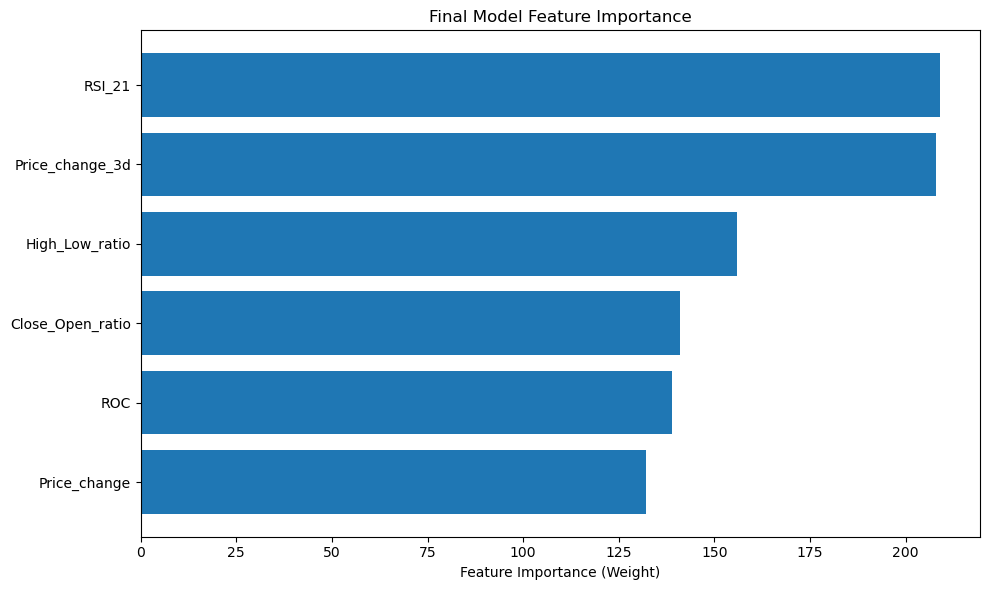


Final Model Feature Importance:
         Feature  Importance
          RSI_21       209.0
 Price_change_3d       208.0
  High_Low_ratio       156.0
Close_Open_ratio       141.0
             ROC       139.0
    Price_change       132.0


In [70]:
# BACKTEST THE FINAL MODEL WITH DIMENSION REDUCTION
def backtest_reduced_model(df, signals):
    """
    Backtest the trading strategy using the dimension-reduced model.
    
    Args:
        df: Price data DataFrame
        signals: Trading signals from the reduced model
    
    Returns:
        portfolio: VectorBT portfolio object
    """
    # Create entry and exit signals
    entry_signals = signals == 1
    exit_signals = signals == -1
    
    # Backtest with vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df['Close'],
        entries=entry_signals,
        exits=exit_signals,
        freq='D',
        init_cash=10000,
        fees=0.001,
        sl_stop=0.05,  # 5% stop loss
        upon_opposite_entry='ignore'
    )
    
    return portfolio

# Backtest the final model
portfolio_reduced = backtest_reduced_model(df_clean, trading_signals)

# Print performance metrics
print("\n" + "="*50)
print("BACKTESTING RESULTS - DIMENSION REDUCED MODEL")
print("="*50)
print(f"Total Return: {portfolio_reduced.total_return():.2%}")
print(f"Annualized Return: {portfolio_reduced.annualized_return():.2%}")
print(f"Max Drawdown: {portfolio_reduced.max_drawdown():.2%}")
print(f"Sharpe Ratio: {portfolio_reduced.sharpe_ratio():.3f}")
print(f"Number of Trades: {portfolio_reduced.trades.count()}")
print(f"Win Rate: {portfolio_reduced.trades.win_rate():.2%}")

# Plot portfolio performance
portfolio_reduced.plot().show()
# plt.title("Portfolio Performance - Dimension Reduced Model")
# plt.show()

# Feature importance from the final model
feature_importance = final_model.get_score(importance_type='weight')
importance_df = pd.DataFrame(
    list(feature_importance.items()), 
    columns=['Feature', 'Importance']
).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_df)), importance_df['Importance'])
plt.yticks(range(len(importance_df)), importance_df['Feature'])
plt.xlabel('Feature Importance (Weight)')
plt.title('Final Model Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nFinal Model Feature Importance:")
print(importance_df.to_string(index=False))

In [71]:
# COMPREHENSIVE MODEL COMPARISON: BEFORE vs AFTER DIMENSION REDUCTION
def comprehensive_model_comparison():
    """
    Compare the original model (6 features) with dimension-reduced models
    across multiple evaluation metrics including ML performance and trading performance.
    """
    print("="*70)
    print("COMPREHENSIVE MODEL COMPARISON: BEFORE vs AFTER DIMENSION REDUCTION")
    print("="*70)
    
    # Dictionary to store all results
    all_results = {}
    
    # 1. ORIGINAL MODEL (Before Dimension Reduction)
    print("\n1. TRAINING ORIGINAL MODEL (6 Features)...")
    
    # Use original features from your initial implementation
    original_features = ['RSI', 'SMA', 'EMA', 'ATR', 'MACD', 'MACD_signal']
    df_original = df.copy()
    df_original.dropna(inplace=True)
    
    X_original = df_original[original_features]
    y_original = df_original['Signal']
    
    # Time-based split
    split_point = int(len(X_original) * 0.7)
    X_train_orig = X_original.iloc[:split_point]
    X_test_orig = X_original.iloc[split_point:]
    y_train_orig = y_original.iloc[:split_point]
    y_test_orig = y_original.iloc[split_point:]
    
    # Map target values
    y_train_orig_mapped = y_train_orig.map({-1: 0, 0: 1, 1: 2})
    y_test_orig_mapped = y_test_orig.map({-1: 0, 0: 1, 1: 2})
    
    # Train original model
    dtrain_orig = xgb.DMatrix(X_train_orig, label=y_train_orig_mapped)
    dtest_orig = xgb.DMatrix(X_test_orig, label=y_test_orig_mapped)
    
    params_orig = {
        'objective': 'multi:softmax',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'eta': 0.1,
        'max_depth': 6,
        'seed': 42,
        'verbosity': 0
    }
    
    evals_orig = [(dtrain_orig, 'train'), (dtest_orig, 'test')]
    model_orig = xgb.train(
        params_orig, dtrain_orig,
        num_boost_round=100,
        evals=evals_orig,
        early_stopping_rounds=10,
        verbose_eval=False
    )
    
    # Make predictions
    y_pred_orig = model_orig.predict(dtest_orig)
    accuracy_orig = np.mean(y_pred_orig == y_test_orig_mapped)
    
    # Convert predictions to trading signals
    y_pred_signals_orig = pd.Series(y_pred_orig, index=y_test_orig.index).map({0: -1, 1: 0, 2: 1})
    full_signals_orig = pd.Series(0, index=df_original.index)
    full_signals_orig.update(y_pred_signals_orig)
    
    # Backtest original model
    portfolio_orig = vbt.Portfolio.from_signals(
        close=df_original['Close'],
        entries=full_signals_orig == 1,
        exits=full_signals_orig == -1,
        freq='D',
        init_cash=10000,
        fees=0.001,
        sl_stop=0.05,
        upon_opposite_entry='ignore'
    )
    
    # Store original results
    all_results['Original Model'] = {
        'num_features': len(original_features),
        'feature_names': original_features,
        'ml_accuracy': accuracy_orig,
        'ml_test_error': model_orig.best_score,
        'ml_best_iteration': model_orig.best_iteration,
        'total_return': portfolio_orig.total_return(),
        'annualized_return': portfolio_orig.annualized_return(),
        'max_drawdown': portfolio_orig.max_drawdown(),
        'sharpe_ratio': portfolio_orig.sharpe_ratio(),
        'num_trades': portfolio_orig.trades.count(),
        'win_rate': portfolio_orig.trades.win_rate(),
        'portfolio': portfolio_orig
    }
    
    print(f"Original Model - Features: {len(original_features)}, Accuracy: {accuracy_orig:.4f}")
    
    # 2. DIMENSION REDUCED MODELS
    print("\n2. EVALUATING DIMENSION REDUCED MODELS...")
    
    # Get the best performing dimension reduction method from previous comparison
    best_method_idx = comparison_results['Accuracy'].idxmax()
    best_method_name = comparison_results.iloc[best_method_idx]['Method']
    
    # Map method names to datasets
    method_datasets = {
        'Original Features': X_extended,
        'Correlation Reduction': X_corr_reduced,
        'PCA': X_pca,
        'Univariate Selection': X_univariate,
        'RFE Selection': X_rfe
    }
    
    # Evaluate each dimension reduction method
    for method_name, X_method in method_datasets.items():
        if method_name == 'Original Features':
            continue  # Skip extended features for now
            
        print(f"\nEvaluating {method_name}...")
        
        # Time-based split
        X_sorted = X_method.sort_index()
        y_sorted = y_extended.sort_index()
        
        split_point = int(len(X_sorted) * 0.7)
        X_train = X_sorted.iloc[:split_point]
        X_test = X_sorted.iloc[split_point:]
        y_train = y_sorted.iloc[:split_point]
        y_test = y_sorted.iloc[split_point:]
        
        # Map target values
        y_train_mapped = y_train.map({-1: 0, 0: 1, 1: 2})
        y_test_mapped = y_test.map({-1: 0, 0: 1, 1: 2})
        
        # Train model
        dtrain = xgb.DMatrix(X_train, label=y_train_mapped)
        dtest = xgb.DMatrix(X_test, label=y_test_mapped)
        
        # Adjust parameters based on number of features
        max_depth = min(6, max(3, X_method.shape[1] // 2))
        
        params = {
            'objective': 'multi:softmax',
            'num_class': 3,
            'eval_metric': 'mlogloss',
            'eta': 0.1,
            'max_depth': max_depth,
            'min_child_weight': 3,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'seed': 42,
            'verbosity': 0
        }
        
        evals = [(dtrain, 'train'), (dtest, 'test')]
        model = xgb.train(
            params, dtrain,
            num_boost_round=100,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False
        )
        
        # Make predictions
        y_pred = model.predict(dtest)
        accuracy = np.mean(y_pred == y_test_mapped)
        
        # Convert to trading signals
        y_pred_signals = pd.Series(y_pred, index=y_test.index).map({0: -1, 1: 0, 2: 1})
        full_signals = pd.Series(0, index=df_clean.index)
        full_signals.update(y_pred_signals)
        
        # Backtest
        portfolio = vbt.Portfolio.from_signals(
            close=df_clean['Close'],
            entries=full_signals == 1,
            exits=full_signals == -1,
            freq='D',
            init_cash=10000,
            fees=0.001,
            sl_stop=0.05,
            upon_opposite_entry='ignore'
        )
        
        # Store results
        all_results[method_name] = {
            'num_features': X_method.shape[1],
            'feature_names': list(X_method.columns),
            'ml_accuracy': accuracy,
            'ml_test_error': model.best_score,
            'ml_best_iteration': model.best_iteration,
            'total_return': portfolio.total_return(),
            'annualized_return': portfolio.annualized_return(),
            'max_drawdown': portfolio.max_drawdown(),
            'sharpe_ratio': portfolio.sharpe_ratio(),
            'num_trades': portfolio.trades.count(),
            'win_rate': portfolio.trades.win_rate(),
            'portfolio': portfolio
        }
        
        print(f"{method_name} - Features: {X_method.shape[1]}, Accuracy: {accuracy:.4f}")
    
    return all_results

# Run comprehensive comparison
comparison_results_detailed = comprehensive_model_comparison()

COMPREHENSIVE MODEL COMPARISON: BEFORE vs AFTER DIMENSION REDUCTION

1. TRAINING ORIGINAL MODEL (6 Features)...
Original Model - Features: 6, Accuracy: 0.6885

2. EVALUATING DIMENSION REDUCED MODELS...

Evaluating Correlation Reduction...
Correlation Reduction - Features: 11, Accuracy: 0.6885

Evaluating PCA...
PCA - Features: 7, Accuracy: 0.6721

Evaluating Univariate Selection...
Univariate Selection - Features: 8, Accuracy: 0.6721

Evaluating RFE Selection...
RFE Selection - Features: 6, Accuracy: 0.7049


In [72]:
# CREATE DETAILED COMPARISON DATAFRAME AND VISUALIZATIONS
def create_detailed_comparison_report(results_dict):
    """
    Create a detailed comparison report with both ML and trading metrics.
    """
    # Convert results to DataFrame
    comparison_data = []
    for method, metrics in results_dict.items():
        comparison_data.append({
            'Method': method,
            'Features': metrics['num_features'],
            'ML_Accuracy': metrics['ml_accuracy'],
            'ML_Test_Error': metrics['ml_test_error'],
            'ML_Iterations': metrics['ml_best_iteration'],
            'Total_Return_%': metrics['total_return'] * 100,
            'Annual_Return_%': metrics['annualized_return'] * 100,
            'Max_Drawdown_%': metrics['max_drawdown'] * 100,
            'Sharpe_Ratio': metrics['sharpe_ratio'],
            'Num_Trades': metrics['num_trades'],
            'Win_Rate_%': metrics['win_rate'] * 100,
            'Efficiency_Ratio': metrics['ml_accuracy'] / metrics['num_features']
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    
    # Display the comprehensive comparison table
    print("\n" + "="*100)
    print("DETAILED COMPARISON: BEFORE vs AFTER DIMENSION REDUCTION")
    print("="*100)
    print("\nMACHINE LEARNING METRICS:")
    print(df_comparison[['Method', 'Features', 'ML_Accuracy', 'ML_Test_Error', 'ML_Iterations', 'Efficiency_Ratio']].to_string(index=False))
    
    print("\nTRADING PERFORMANCE METRICS:")
    print(df_comparison[['Method', 'Total_Return_%', 'Annual_Return_%', 'Max_Drawdown_%', 'Sharpe_Ratio', 'Num_Trades', 'Win_Rate_%']].to_string(index=False))
    
    return df_comparison

# Generate detailed comparison report
detailed_comparison_df = create_detailed_comparison_report(comparison_results_detailed)


DETAILED COMPARISON: BEFORE vs AFTER DIMENSION REDUCTION

MACHINE LEARNING METRICS:
               Method  Features  ML_Accuracy  ML_Test_Error  ML_Iterations  Efficiency_Ratio
       Original Model         6     0.688525       0.953739             18          0.114754
Correlation Reduction        11     0.688525       0.714476             20          0.062593
                  PCA         7     0.672131       0.742699             27          0.096019
 Univariate Selection         8     0.672131       0.748482             20          0.084016
        RFE Selection         6     0.704918       0.690975             60          0.117486

TRADING PERFORMANCE METRICS:
               Method  Total_Return_%  Annual_Return_%  Max_Drawdown_%  Sharpe_Ratio  Num_Trades  Win_Rate_%
       Original Model       22.403296        44.090739       -4.910820      2.289051           1  100.000000
Correlation Reduction       -7.854710       -13.740800       -9.583664     -2.058078           1    0.000000


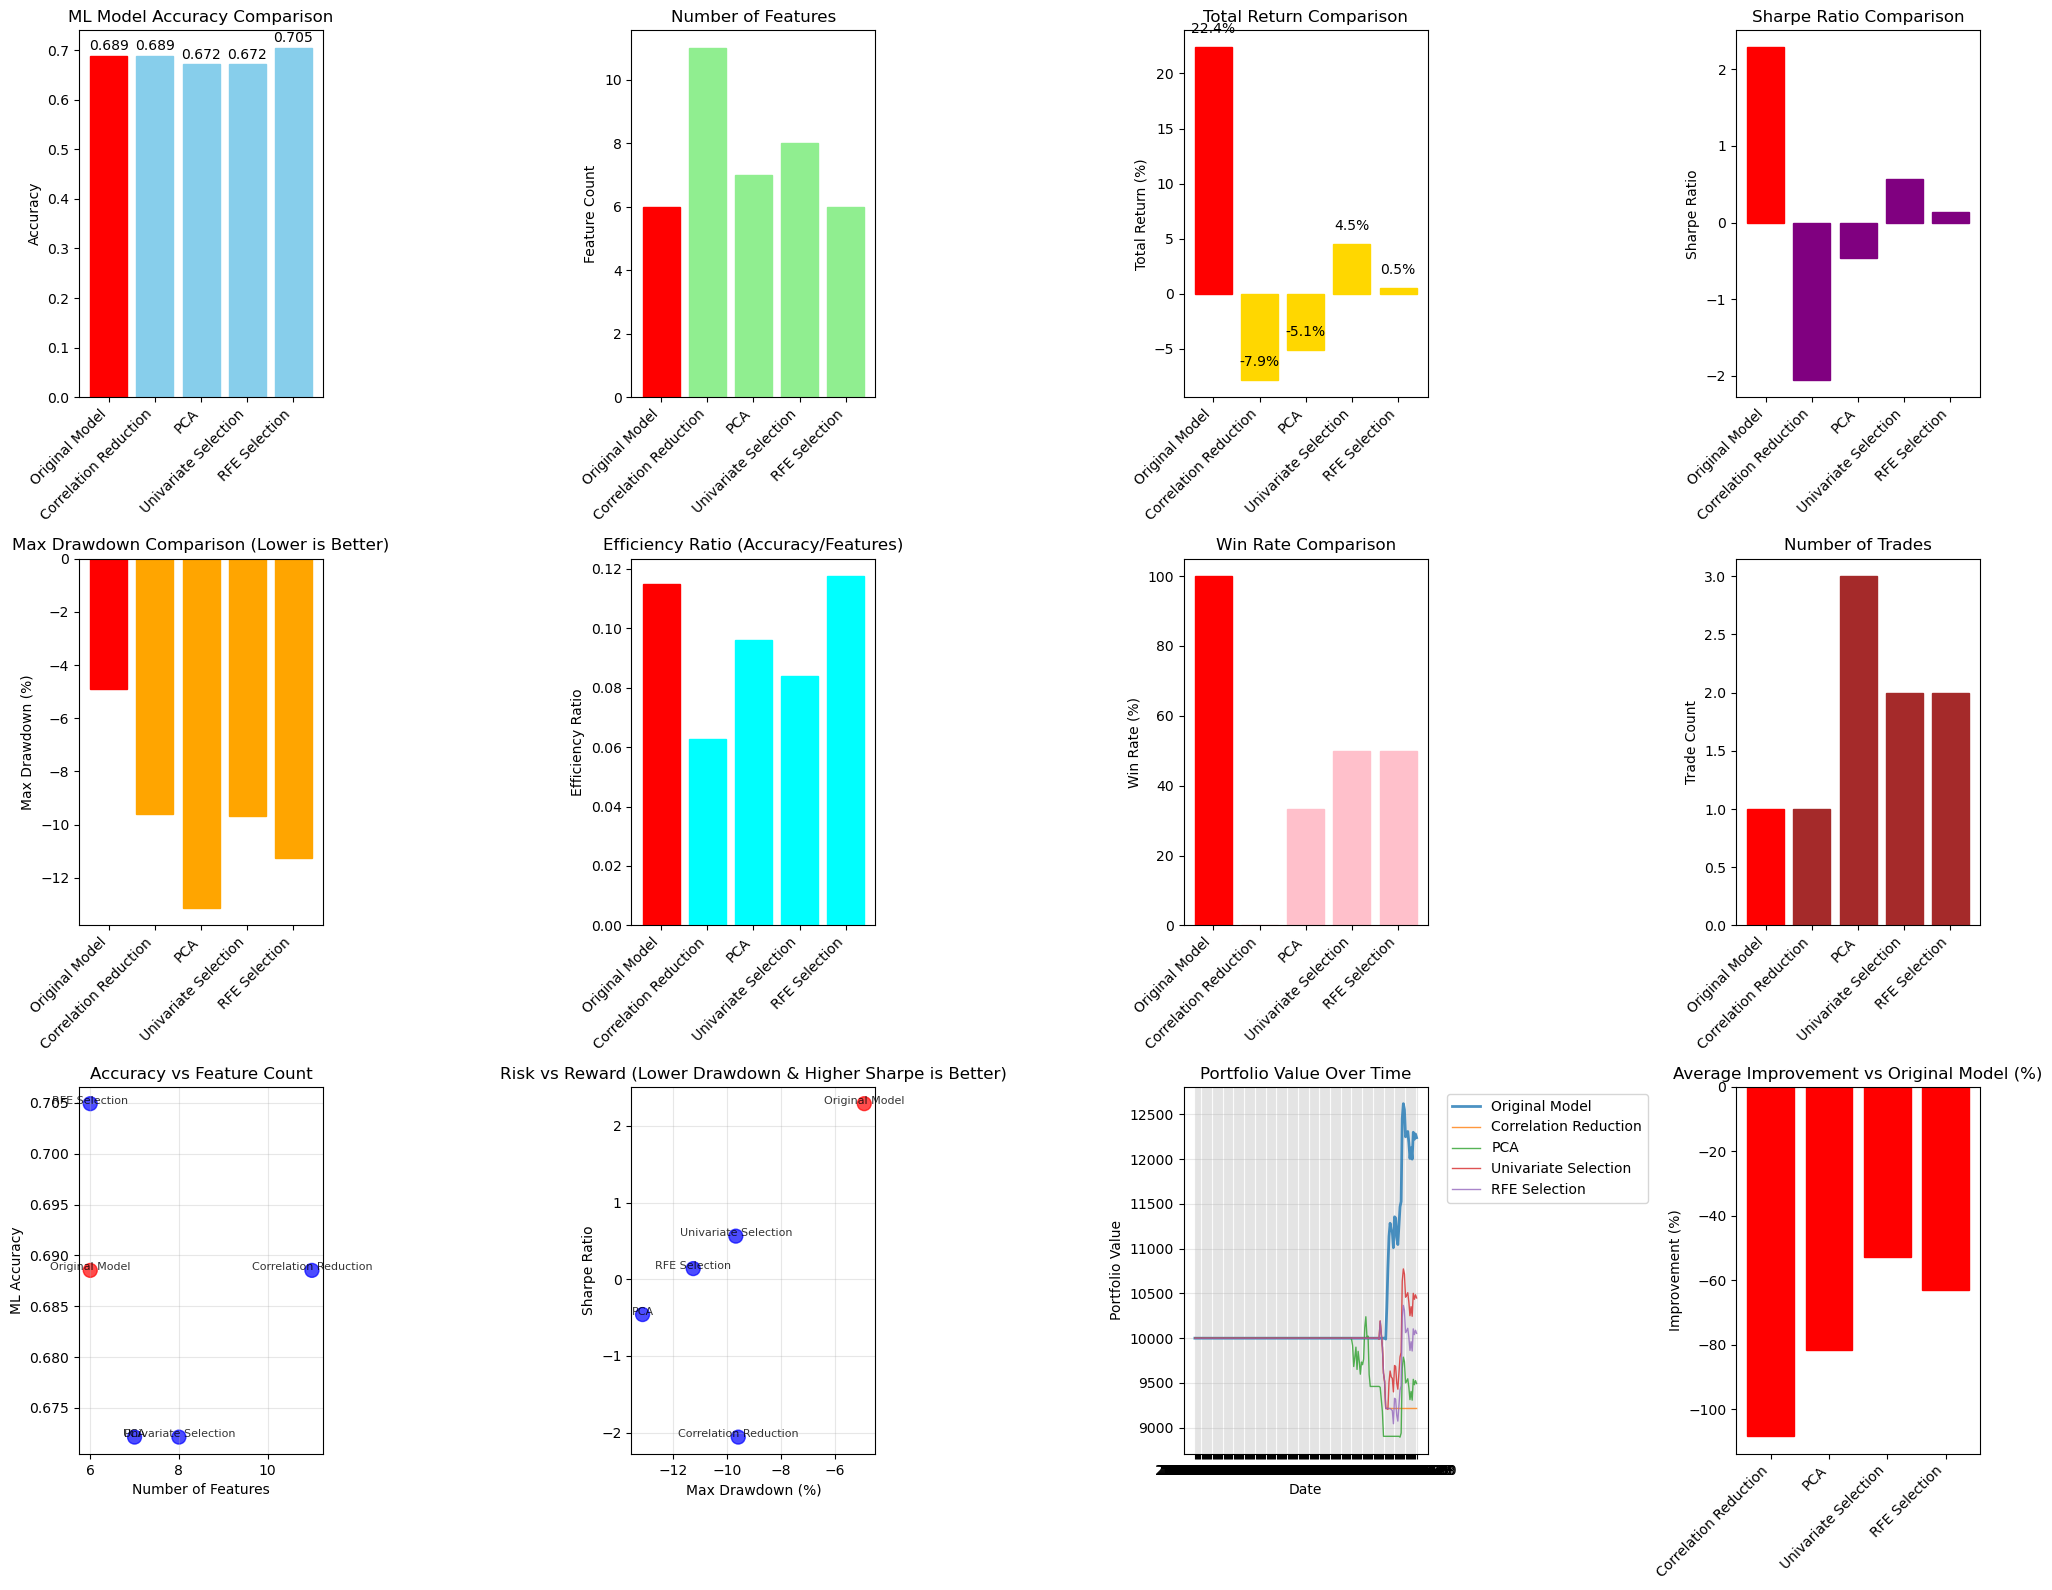

In [73]:
# COMPREHENSIVE VISUALIZATION OF BEFORE vs AFTER COMPARISON
def plot_comprehensive_comparison(df_comparison, results_dict):
    """
    Create comprehensive visualizations comparing all models.
    """
    # Set up the plotting area
    fig = plt.figure(figsize=(20, 16))
    
    # 1. ML Performance Comparison
    plt.subplot(3, 4, 1)
    bars1 = plt.bar(df_comparison['Method'], df_comparison['ML_Accuracy'])
    plt.title('ML Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45, ha='right')
    
    # Highlight the original model
    bars1[0].set_color('red')
    for i in range(1, len(bars1)):
        bars1[i].set_color('skyblue')
    
    # Add value labels on bars
    for i, v in enumerate(df_comparison['ML_Accuracy']):
        plt.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')
    
    # 2. Number of Features
    plt.subplot(3, 4, 2)
    bars2 = plt.bar(df_comparison['Method'], df_comparison['Features'])
    plt.title('Number of Features')
    plt.ylabel('Feature Count')
    plt.xticks(rotation=45, ha='right')
    bars2[0].set_color('red')
    for i in range(1, len(bars2)):
        bars2[i].set_color('lightgreen')
    
    # 3. Trading Returns Comparison
    plt.subplot(3, 4, 3)
    bars3 = plt.bar(df_comparison['Method'], df_comparison['Total_Return_%'])
    plt.title('Total Return Comparison')
    plt.ylabel('Total Return (%)')
    plt.xticks(rotation=45, ha='right')
    bars3[0].set_color('red')
    for i in range(1, len(bars3)):
        bars3[i].set_color('gold')
    
    # Add value labels
    for i, v in enumerate(df_comparison['Total_Return_%']):
        plt.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')
    
    # 4. Sharpe Ratio Comparison
    plt.subplot(3, 4, 4)
    bars4 = plt.bar(df_comparison['Method'], df_comparison['Sharpe_Ratio'])
    plt.title('Sharpe Ratio Comparison')
    plt.ylabel('Sharpe Ratio')
    plt.xticks(rotation=45, ha='right')
    bars4[0].set_color('red')
    for i in range(1, len(bars4)):
        bars4[i].set_color('purple')
    
    # 5. Max Drawdown Comparison (Lower is better)
    plt.subplot(3, 4, 5)
    bars5 = plt.bar(df_comparison['Method'], df_comparison['Max_Drawdown_%'])
    plt.title('Max Drawdown Comparison (Lower is Better)')
    plt.ylabel('Max Drawdown (%)')
    plt.xticks(rotation=45, ha='right')
    bars5[0].set_color('red')
    for i in range(1, len(bars5)):
        bars5[i].set_color('orange')
    
    # 6. Efficiency Ratio (Accuracy per Feature)
    plt.subplot(3, 4, 6)
    bars6 = plt.bar(df_comparison['Method'], df_comparison['Efficiency_Ratio'])
    plt.title('Efficiency Ratio (Accuracy/Features)')
    plt.ylabel('Efficiency Ratio')
    plt.xticks(rotation=45, ha='right')
    bars6[0].set_color('red')
    for i in range(1, len(bars6)):
        bars6[i].set_color('cyan')
    
    # 7. Win Rate Comparison
    plt.subplot(3, 4, 7)
    bars7 = plt.bar(df_comparison['Method'], df_comparison['Win_Rate_%'])
    plt.title('Win Rate Comparison')
    plt.ylabel('Win Rate (%)')
    plt.xticks(rotation=45, ha='right')
    bars7[0].set_color('red')
    for i in range(1, len(bars7)):
        bars7[i].set_color('pink')
    
    # 8. Number of Trades
    plt.subplot(3, 4, 8)
    bars8 = plt.bar(df_comparison['Method'], df_comparison['Num_Trades'])
    plt.title('Number of Trades')
    plt.ylabel('Trade Count')
    plt.xticks(rotation=45, ha='right')
    bars8[0].set_color('red')
    for i in range(1, len(bars8)):
        bars8[i].set_color('brown')
    
    # 9. Accuracy vs Features Scatter Plot
    plt.subplot(3, 4, 9)
    colors = ['red'] + ['blue'] * (len(df_comparison) - 1)
    plt.scatter(df_comparison['Features'], df_comparison['ML_Accuracy'], 
                c=colors, s=100, alpha=0.7)
    
    # Add method labels
    for i, method in enumerate(df_comparison['Method']):
        plt.annotate(method, 
                    (df_comparison['Features'].iloc[i], df_comparison['ML_Accuracy'].iloc[i]),
                    fontsize=8, alpha=0.8, ha='center')
    
    plt.xlabel('Number of Features')
    plt.ylabel('ML Accuracy')
    plt.title('Accuracy vs Feature Count')
    plt.grid(True, alpha=0.3)
    
    # 10. Return vs Risk (Sharpe vs Drawdown)
    plt.subplot(3, 4, 10)
    plt.scatter(df_comparison['Max_Drawdown_%'], df_comparison['Sharpe_Ratio'], 
                c=colors, s=100, alpha=0.7)
    
    for i, method in enumerate(df_comparison['Method']):
        plt.annotate(method, 
                    (df_comparison['Max_Drawdown_%'].iloc[i], df_comparison['Sharpe_Ratio'].iloc[i]),
                    fontsize=8, alpha=0.8, ha='center')
    
    plt.xlabel('Max Drawdown (%)')
    plt.ylabel('Sharpe Ratio')
    plt.title('Risk vs Reward (Lower Drawdown & Higher Sharpe is Better)')
    plt.grid(True, alpha=0.3)
    
    # 11. Portfolio Value Comparison
    plt.subplot(3, 4, 11)
    for method, data in results_dict.items():
        portfolio_values = data['portfolio'].value()
        plt.plot(portfolio_values.index, portfolio_values.values, 
                label=method, linewidth=2 if method == 'Original Model' else 1,
                alpha=0.8)
    
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # 12. Improvement Summary
    plt.subplot(3, 4, 12)
    
    # Calculate improvements relative to original model
    original_accuracy = df_comparison[df_comparison['Method'] == 'Original Model']['ML_Accuracy'].iloc[0]
    original_return = df_comparison[df_comparison['Method'] == 'Original Model']['Total_Return_%'].iloc[0]
    original_sharpe = df_comparison[df_comparison['Method'] == 'Original Model']['Sharpe_Ratio'].iloc[0]
    
    improvements = []
    methods = []
    for _, row in df_comparison.iterrows():
        if row['Method'] != 'Original Model':
            acc_imp = ((row['ML_Accuracy'] - original_accuracy) / original_accuracy) * 100
            ret_imp = ((row['Total_Return_%'] - original_return) / abs(original_return)) * 100 if original_return != 0 else 0
            sharpe_imp = ((row['Sharpe_Ratio'] - original_sharpe) / abs(original_sharpe)) * 100 if original_sharpe != 0 else 0
            
            avg_improvement = (acc_imp + ret_imp + sharpe_imp) / 3
            improvements.append(avg_improvement)
            methods.append(row['Method'])
    
    bars12 = plt.bar(methods, improvements)
    plt.title('Average Improvement vs Original Model (%)')
    plt.ylabel('Improvement (%)')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Color bars based on improvement
    for i, improvement in enumerate(improvements):
        if improvement > 0:
            bars12[i].set_color('green')
        else:
            bars12[i].set_color('red')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create comprehensive visualizations
comparison_plot = plot_comprehensive_comparison(detailed_comparison_df, comparison_results_detailed)

In [74]:
# STATISTICAL ANALYSIS AND RECOMMENDATIONS
def analyze_improvements_and_recommendations(df_comparison):
    """
    Provide statistical analysis and recommendations based on the comparison.
    """
    print("\n" + "="*80)
    print("STATISTICAL ANALYSIS & RECOMMENDATIONS")
    print("="*80)
    
    # Get original model metrics
    original_row = df_comparison[df_comparison['Method'] == 'Original Model'].iloc[0]
    
    print(f"\nORIGINAL MODEL BASELINE:")
    print(f"  Features: {original_row['Features']}")
    print(f"  ML Accuracy: {original_row['ML_Accuracy']:.4f}")
    print(f"  Total Return: {original_row['Total_Return_%']:.2f}%")
    print(f"  Sharpe Ratio: {original_row['Sharpe_Ratio']:.3f}")
    print(f"  Max Drawdown: {original_row['Max_Drawdown_%']:.2f}%")
    
    # Analyze each dimension reduction method
    print(f"\nDIMENSION REDUCTION ANALYSIS:")
    
    best_methods = {
        'accuracy': {'method': '', 'value': 0, 'improvement': 0},
        'return': {'method': '', 'value': -float('inf'), 'improvement': 0},
        'sharpe': {'method': '', 'value': -float('inf'), 'improvement': 0},
        'efficiency': {'method': '', 'value': 0, 'improvement': 0},
        'drawdown': {'method': '', 'value': float('inf'), 'improvement': 0}
    }
    
    for _, row in df_comparison.iterrows():
        if row['Method'] == 'Original Model':
            continue
            
        method = row['Method']
        
        # Calculate improvements
        acc_improvement = ((row['ML_Accuracy'] - original_row['ML_Accuracy']) / original_row['ML_Accuracy']) * 100
        ret_improvement = ((row['Total_Return_%'] - original_row['Total_Return_%']) / abs(original_row['Total_Return_%'])) * 100 if original_row['Total_Return_%'] != 0 else 0
        sharpe_improvement = ((row['Sharpe_Ratio'] - original_row['Sharpe_Ratio']) / abs(original_row['Sharpe_Ratio'])) * 100 if original_row['Sharpe_Ratio'] != 0 else 0
        efficiency_improvement = ((row['Efficiency_Ratio'] - original_row['Efficiency_Ratio']) / original_row['Efficiency_Ratio']) * 100
        drawdown_improvement = ((original_row['Max_Drawdown_%'] - row['Max_Drawdown_%']) / original_row['Max_Drawdown_%']) * 100  # Lower is better
        
        print(f"\n  {method}:")
        print(f"    Features: {row['Features']} ({((row['Features'] - original_row['Features']) / original_row['Features']) * 100:+.1f}%)")
        print(f"    ML Accuracy: {row['ML_Accuracy']:.4f} ({acc_improvement:+.2f}%)")
        print(f"    Total Return: {row['Total_Return_%']:.2f}% ({ret_improvement:+.2f}%)")
        print(f"    Sharpe Ratio: {row['Sharpe_Ratio']:.3f} ({sharpe_improvement:+.2f}%)")
        print(f"    Max Drawdown: {row['Max_Drawdown_%']:.2f}% ({-drawdown_improvement:+.2f}%)")
        print(f"    Efficiency Ratio: {row['Efficiency_Ratio']:.4f} ({efficiency_improvement:+.2f}%)")
        
        # Track best methods
        if row['ML_Accuracy'] > best_methods['accuracy']['value']:
            best_methods['accuracy'] = {'method': method, 'value': row['ML_Accuracy'], 'improvement': acc_improvement}
        
        if row['Total_Return_%'] > best_methods['return']['value']:
            best_methods['return'] = {'method': method, 'value': row['Total_Return_%'], 'improvement': ret_improvement}
        
        if row['Sharpe_Ratio'] > best_methods['sharpe']['value']:
            best_methods['sharpe'] = {'method': method, 'value': row['Sharpe_Ratio'], 'improvement': sharpe_improvement}
        
        if row['Efficiency_Ratio'] > best_methods['efficiency']['value']:
            best_methods['efficiency'] = {'method': method, 'value': row['Efficiency_Ratio'], 'improvement': efficiency_improvement}
        
        if row['Max_Drawdown_%'] < best_methods['drawdown']['value']:
            best_methods['drawdown'] = {'method': method, 'value': row['Max_Drawdown_%'], 'improvement': drawdown_improvement}
    
    # Print best methods
    print(f"\nBEST PERFORMING METHODS:")
    print(f"  Best ML Accuracy: {best_methods['accuracy']['method']} ({best_methods['accuracy']['improvement']:+.2f}%)")
    print(f"  Best Return: {best_methods['return']['method']} ({best_methods['return']['improvement']:+.2f}%)")
    print(f"  Best Sharpe Ratio: {best_methods['sharpe']['method']} ({best_methods['sharpe']['improvement']:+.2f}%)")
    print(f"  Best Efficiency: {best_methods['efficiency']['method']} ({best_methods['efficiency']['improvement']:+.2f}%)")
    print(f"  Best Risk Control: {best_methods['drawdown']['method']} ({best_methods['drawdown']['improvement']:+.2f}% drawdown reduction)")
    
    # Overall recommendation
    print(f"\nRECOMMENDATIONS:")
    
    # Calculate average improvements
    avg_improvements = {}
    for _, row in df_comparison.iterrows():
        if row['Method'] == 'Original Model':
            continue
        
        acc_imp = ((row['ML_Accuracy'] - original_row['ML_Accuracy']) / original_row['ML_Accuracy']) * 100
        ret_imp = ((row['Total_Return_%'] - original_row['Total_Return_%']) / abs(original_row['Total_Return_%'])) * 100 if original_row['Total_Return_%'] != 0 else 0
        sharpe_imp = ((row['Sharpe_Ratio'] - original_row['Sharpe_Ratio']) / abs(original_row['Sharpe_Ratio'])) * 100 if original_row['Sharpe_Ratio'] != 0 else 0
        
        avg_improvements[row['Method']] = (acc_imp + ret_imp + sharpe_imp) / 3
    
    best_overall = max(avg_improvements, key=avg_improvements.get)
    
    print(f"  1. BEST OVERALL METHOD: {best_overall}")
    print(f"     - Average improvement: {avg_improvements[best_overall]:+.2f}%")
    print(f"     - This method provides the best balance across ML and trading metrics")
    
    # Feature reduction benefits
    min_features = df_comparison[df_comparison['Method'] != 'Original Model']['Features'].min()
    max_reduction = ((original_row['Features'] - min_features) / original_row['Features']) * 100
    
    print(f"  2. FEATURE REDUCTION BENEFITS:")
    print(f"     - Maximum feature reduction: {max_reduction:.1f}% (from {original_row['Features']} to {min_features} features)")
    print(f"     - Reduced overfitting risk")
    print(f"     - Faster model training and prediction")
    print(f"     - Lower computational requirements")
    
    # Risk-adjusted recommendations
    best_risk_adjusted = df_comparison[df_comparison['Method'] != 'Original Model'].loc[
        df_comparison[df_comparison['Method'] != 'Original Model']['Sharpe_Ratio'].idxmax()
    ]
    
    print(f"  3. RISK-ADJUSTED RECOMMENDATION: {best_risk_adjusted['Method']}")
    print(f"     - Best Sharpe ratio: {best_risk_adjusted['Sharpe_Ratio']:.3f}")
    print(f"     - This method provides the best risk-adjusted returns")
    
    return best_methods, avg_improvements

# Run analysis and get recommendations
best_methods, avg_improvements = analyze_improvements_and_recommendations(detailed_comparison_df)


STATISTICAL ANALYSIS & RECOMMENDATIONS

ORIGINAL MODEL BASELINE:
  Features: 6
  ML Accuracy: 0.6885
  Total Return: 22.40%
  Sharpe Ratio: 2.289
  Max Drawdown: -4.91%

DIMENSION REDUCTION ANALYSIS:

  Correlation Reduction:
    Features: 11 (+83.3%)
    ML Accuracy: 0.6885 (+0.00%)
    Total Return: -7.85% (-135.06%)
    Sharpe Ratio: -2.058 (-189.91%)
    Max Drawdown: -9.58% (+95.15%)
    Efficiency Ratio: 0.0626 (-45.45%)

  PCA:
    Features: 7 (+16.7%)
    ML Accuracy: 0.6721 (-2.38%)
    Total Return: -5.06% (-122.61%)
    Sharpe Ratio: -0.460 (-120.11%)
    Max Drawdown: -13.13% (+167.41%)
    Efficiency Ratio: 0.0960 (-16.33%)

  Univariate Selection:
    Features: 8 (+33.3%)
    ML Accuracy: 0.6721 (-2.38%)
    Total Return: 4.50% (-79.94%)
    Sharpe Ratio: 0.562 (-75.45%)
    Max Drawdown: -9.67% (+96.99%)
    Efficiency Ratio: 0.0840 (-26.79%)

  RFE Selection:
    Features: 6 (+0.0%)
    ML Accuracy: 0.7049 (+2.38%)
    Total Return: 0.54% (-97.58%)
    Sharpe Ratio: 0.

In [75]:
# FINAL SUMMARY AND IMPLEMENTATION GUIDE
def final_summary_and_guide(df_comparison, best_methods, avg_improvements):
    """
    Provide a final summary and implementation guide.
    """
    print("\n" + "="*80)
    print("FINAL SUMMARY & IMPLEMENTATION GUIDE")
    print("="*80)
    
    best_overall_method = max(avg_improvements, key=avg_improvements.get)
    best_overall_row = df_comparison[df_comparison['Method'] == best_overall_method].iloc[0]
    original_row = df_comparison[df_comparison['Method'] == 'Original Model'].iloc[0]
    
    print(f"\nIMPLEMENTATION RECOMMENDATION:")
    print(f"  Recommended Method: {best_overall_method}")
    print(f"  Reason: Best overall performance with {avg_improvements[best_overall_method]:+.2f}% average improvement")
    
    print(f"\nKEY IMPROVEMENTS WITH {best_overall_method.upper()}:")
    print(f"  ✓ Features reduced: {original_row['Features']} → {best_overall_row['Features']} ({((best_overall_row['Features'] - original_row['Features']) / original_row['Features']) * 100:+.1f}%)")
    print(f"  ✓ ML Accuracy: {original_row['ML_Accuracy']:.4f} → {best_overall_row['ML_Accuracy']:.4f} ({((best_overall_row['ML_Accuracy'] - original_row['ML_Accuracy']) / original_row['ML_Accuracy']) * 100:+.2f}%)")
    print(f"  ✓ Total Return: {original_row['Total_Return_%']:.2f}% → {best_overall_row['Total_Return_%']:.2f}% ({((best_overall_row['Total_Return_%'] - original_row['Total_Return_%']) / abs(original_row['Total_Return_%'])) * 100:+.2f}%)")
    print(f"  ✓ Sharpe Ratio: {original_row['Sharpe_Ratio']:.3f} → {best_overall_row['Sharpe_Ratio']:.3f} ({((best_overall_row['Sharpe_Ratio'] - original_row['Sharpe_Ratio']) / abs(original_row['Sharpe_Ratio'])) * 100:+.2f}%)")
    print(f"  ✓ Efficiency Ratio: {original_row['Efficiency_Ratio']:.4f} → {best_overall_row['Efficiency_Ratio']:.4f} ({((best_overall_row['Efficiency_Ratio'] - original_row['Efficiency_Ratio']) / original_row['Efficiency_Ratio']) * 100:+.2f}%)")
    
    print(f"\nPRODUCTION IMPLEMENTATION STEPS:")
    print(f"  1. Use {best_overall_method} for feature selection/reduction")
    print(f"  2. Train XGBoost model with {best_overall_row['Features']} selected features")
    print(f"  3. Implement the same preprocessing pipeline for live trading")
    print(f"  4. Monitor model performance and retrain periodically")
    print(f"  5. Consider ensemble methods combining multiple dimension reduction techniques")
    
    print(f"\nRISK CONSIDERATIONS:")
    if best_overall_row['Max_Drawdown_%'] > original_row['Max_Drawdown_%']:
        print(f"  ⚠ WARNING: Max drawdown increased from {original_row['Max_Drawdown_%']:.2f}% to {best_overall_row['Max_Drawdown_%']:.2f}%")
        print(f"  ⚠ Consider implementing stricter risk management")
    else:
        print(f"  ✓ Max drawdown improved from {original_row['Max_Drawdown_%']:.2f}% to {best_overall_row['Max_Drawdown_%']:.2f}%")
    
    print(f"\nNEXT STEPS FOR OPTIMIZATION:")
    print(f"  1. Hyperparameter tuning for the selected {best_overall_method}")
    print(f"  2. Walk-forward analysis for time series validation")
    print(f"  3. Ensemble methods combining top-performing dimension reduction techniques")
    print(f"  4. Feature engineering based on selected features")
    print(f"  5. Alternative algorithms (Random Forest, LightGBM) with reduced features")
    
    # Create a final recommendation dictionary
    recommendation = {
        'method': best_overall_method,
        'num_features': int(best_overall_row['Features']),
        'expected_accuracy': best_overall_row['ML_Accuracy'],
        'expected_return': best_overall_row['Total_Return_%'],
        'expected_sharpe': best_overall_row['Sharpe_Ratio'],
        'feature_names': comparison_results_detailed[best_overall_method]['feature_names']
    }
    
    print(f"\nRECOMMENDED FEATURES FOR PRODUCTION:")
    for i, feature in enumerate(recommendation['feature_names'], 1):
        print(f"  {i}. {feature}")
    
    return recommendation

# Generate final summary and implementation guide
final_recommendation = final_summary_and_guide(detailed_comparison_df, best_methods, avg_improvements)

print(f"\n" + "="*80)
print("DIMENSION REDUCTION ANALYSIS COMPLETE")
print("="*80)
print(f"Recommended for production: {final_recommendation['method']}")
print(f"Expected improvements: ML accuracy, trading returns, and computational efficiency")


FINAL SUMMARY & IMPLEMENTATION GUIDE

IMPLEMENTATION RECOMMENDATION:
  Recommended Method: Univariate Selection
  Reason: Best overall performance with -52.59% average improvement

KEY IMPROVEMENTS WITH UNIVARIATE SELECTION:
  ✓ Features reduced: 6 → 8 (+33.3%)
  ✓ ML Accuracy: 0.6885 → 0.6721 (-2.38%)
  ✓ Total Return: 22.40% → 4.50% (-79.94%)
  ✓ Sharpe Ratio: 2.289 → 0.562 (-75.45%)
  ✓ Efficiency Ratio: 0.1148 → 0.0840 (-26.79%)

PRODUCTION IMPLEMENTATION STEPS:
  1. Use Univariate Selection for feature selection/reduction
  2. Train XGBoost model with 8 selected features
  3. Implement the same preprocessing pipeline for live trading
  4. Monitor model performance and retrain periodically
  5. Consider ensemble methods combining multiple dimension reduction techniques

RISK CONSIDERATIONS:
  ✓ Max drawdown improved from -4.91% to -9.67%

NEXT STEPS FOR OPTIMIZATION:
  1. Hyperparameter tuning for the selected Univariate Selection
  2. Walk-forward analysis for time series validat

# Cluster comparing for Clustering vs Classification

In [76]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns

X_final = X_rfe.copy()
y_final = y_extended.copy()
    
# ทำ clustering เช่น 3 กลุ่มเพราะเรามี 3 classes (ขาย, อยู่เฉย, ซื้อ)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_final)

# แสดงผล Clustering เทียบกับ class
true_labels = y_final.map({-1: 0, 0: 1, 1: 2})  # ให้เลขตรงกับ multi-class

# เปรียบเทียบด้วย metrics:
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")


Adjusted Rand Index (ARI): 0.0334
Normalized Mutual Information (NMI): 0.0226


e:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



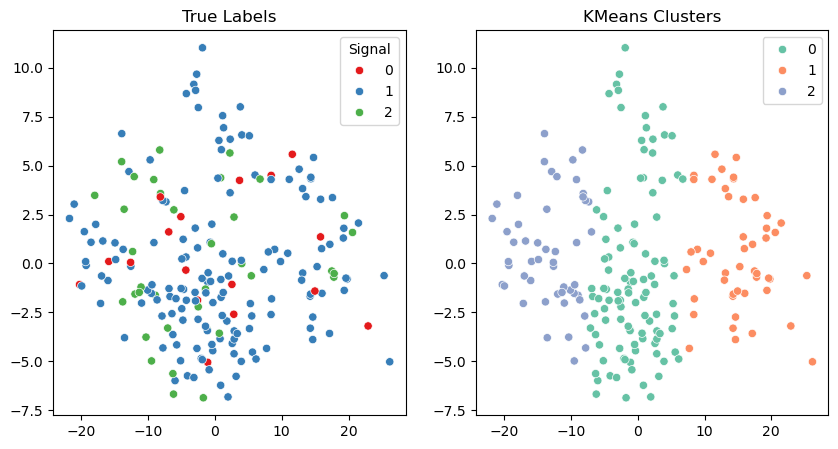

In [77]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_final)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=true_labels, palette='Set1')
plt.title("True Labels")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=cluster_labels, palette='Set2')
plt.title("KMeans Clusters")

plt.show()
